In [34]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [69]:
working_path = "D:/Semester 5/MachineORDeep Learning/Final Project"
# file_names = ['encoded-dogcat-img-16.csv', 'encoded-dogcat-img-32.csv', 'encoded-dogcat-img-64.csv', 'encoded-dogcat-img-128.csv']
file_names = ['encoded-dogcat-img-32.csv']



In [35]:
callbacks = [
    # Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi setelah beberapa epoch
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # ModelCheckpoint untuk menyimpan model dengan akurasi validasi terbaik
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [84]:
models = []
accuracies = []
histories = []

for i, f in enumerate(file_names):
    print(f"==> Start Model {file_names[i]} <==")
    
    # Load dataset
    df = pd.read_csv(f'{working_path}/dataset/dogcat-encode/{f}')
    df = df.iloc[:, 1:]

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]

    # Linear Discriminant Analysis (LDA)
    lda = LinearDiscriminantAnalysis(n_components=min(X.shape[1], y.iloc[:, 0].nunique()-1))
    X_lda = lda.fit_transform(X, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

    # Sequential model initialization
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    
    models.append(model)
    histories.append(history)

    last_accuracy = history.history['val_accuracy'][-1]
    accuracies.append(last_accuracy)

    print(f"==> End Model {file_names[i]} <==")

==> Start Model encoded-dogcat-img-32.csv <==


c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
21/21 [==============================] - 2s 19ms/step - loss: 0.6910 - accuracy: 0.8310 - val_loss: 0.3447 - val_accuracy: 1.0000
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1886 - accuracy: 1.0000 - val_loss: 0.1034 - val_accuracy: 1.0000
Epoch 3/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0617 - accuracy: 1.0000 - val_loss: 0.0454 - val_accuracy: 1.0000
Epoch 4/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 8/50
21/21 [=

In [79]:
# accuracy_per_n = {}


# models = []
# accuracies = []
# histories = []

# for i, f in enumerate(file_names):
#   print(f"==> Start Model {file_names[i]} <==")
#   df = pd.read_csv(f'{working_path}/dataset/dogcat-encode/{f}')
#   df = df.iloc[:,1:]

#   X = df.iloc[:,:-1]
#   y = df.iloc[:,-1:]

#     # Mencoba berbagai nilai n_components
#   for n in range(1, min(X.shape[1], y.iloc[:, 0].nunique())):
#     lda = LinearDiscriminantAnalysis(n_components=n)
#     X_lda = lda.fit_transform(X, y)

#     X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(50, input_shape=(X_train.shape[1],), activation='relu'),
#         tf.keras.layers.Dense(50, activation='relu'),
#         tf.keras.layers.Dense(4, activation='softmax')
#     ])

#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

#     last_accuracy = history.history['val_accuracy'][-1]

#     # Menyimpan akurasi untuk setiap n_components
#     if n in accuracy_per_n:
#         accuracy_per_n[n].append(last_accuracy)
#     else:
#         accuracy_per_n[n] = [last_accuracy]

#     print(f"n_components: {n}, Validation Accuracy: {last_accuracy}")

#   print(f"==> End Model {file_names[i]} <==")


#   # Compile model
#   model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#   # Latih model
#   history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
#   models.append(model)
#   histories.append(history)

#   last_accuracy = history.history['val_accuracy'][-1]  # Mengambil akurasi validasi terakhir
#   accuracies.append(last_accuracy)

#   print(f"==> End Model {file_names[i]} <==")

==> Start Model encoded-dogcat-img-32.csv <==


c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
21/21 [==============================] - 2s 15ms/step - loss: 1.2904 - accuracy: 0.2977 - val_loss: 1.0947 - val_accuracy: 0.4815
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 0.9815 - accuracy: 0.5116 - val_loss: 0.9757 - val_accuracy: 0.4938
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.8767 - accuracy: 0.5566 - val_loss: 0.8944 - val_accuracy: 0.5617
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.7902 - accuracy: 0.6078 - val_loss: 0.8188 - val_accuracy: 0.5802
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.7174 - accuracy: 0.7116 - val_loss: 0.7532 - val_accuracy: 0.6111
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.6479 - accuracy: 0.7550 - val_loss: 0.6955 - val_accuracy: 0.6790
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 0.5850 - accuracy: 0.7674 - val_loss: 0.6482 - val_accuracy: 0.7037
Epoch 8/50
21/21 [=

c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
21/21 [==============================] - 1s 21ms/step - loss: 0.9322 - accuracy: 0.5814 - val_loss: 0.6499 - val_accuracy: 0.6852
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 0.4815 - accuracy: 0.8248 - val_loss: 0.4361 - val_accuracy: 0.8827
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 0.3379 - accuracy: 0.9054 - val_loss: 0.3117 - val_accuracy: 0.9259
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2615 - accuracy: 0.9225 - val_loss: 0.2495 - val_accuracy: 0.9259
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2206 - accuracy: 0.9256 - val_loss: 0.2096 - val_accuracy: 0.9321
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1906 - accuracy: 0.9380 - val_loss: 0.1828 - val_accuracy: 0.9444
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1730 - accuracy: 0.9364 - val_loss: 0.1635 - val_accuracy: 0.9506
Epoch 8/50
21/21 [=

c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
21/21 [==============================] - 1s 19ms/step - loss: 1.4232 - accuracy: 0.3178 - val_loss: 0.7875 - val_accuracy: 0.7716
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 0.5005 - accuracy: 0.9736 - val_loss: 0.2734 - val_accuracy: 1.0000
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1628 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 1.0000
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0662 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 1.0000
Epoch 5/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 1.0000
Epoch 6/50
21/21 [==============================] - 0s 13ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 8/50
21/21 [

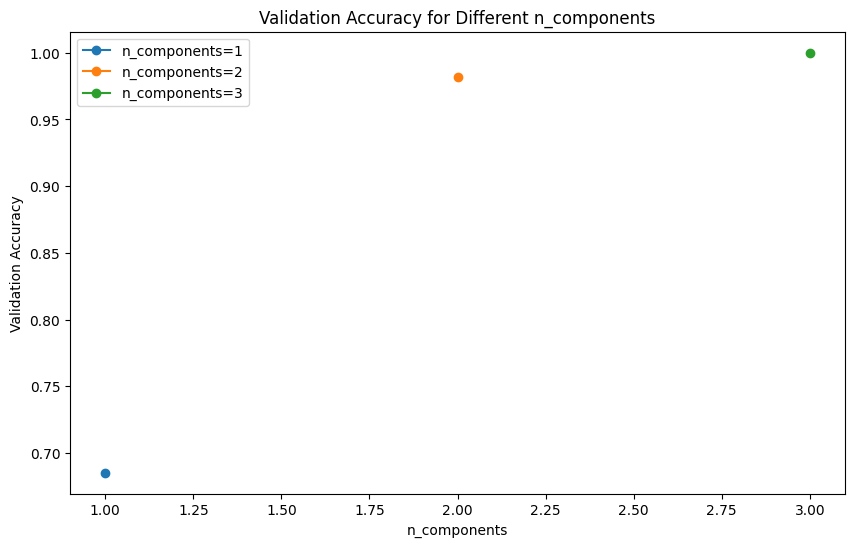

In [82]:
# # Plot hasil akurasi untuk setiap n_components
# plt.figure(figsize=(10, 6))
# for n, accs in accuracy_per_n.items():
#     plt.plot([n] * len(accs), accs, marker='o', linestyle='-', label=f'n_components={n}')

# plt.xlabel('n_components')
# plt.ylabel('Validation Accuracy')
# plt.legend()
# plt.title('Validation Accuracy for Different n_components')
# plt.show()


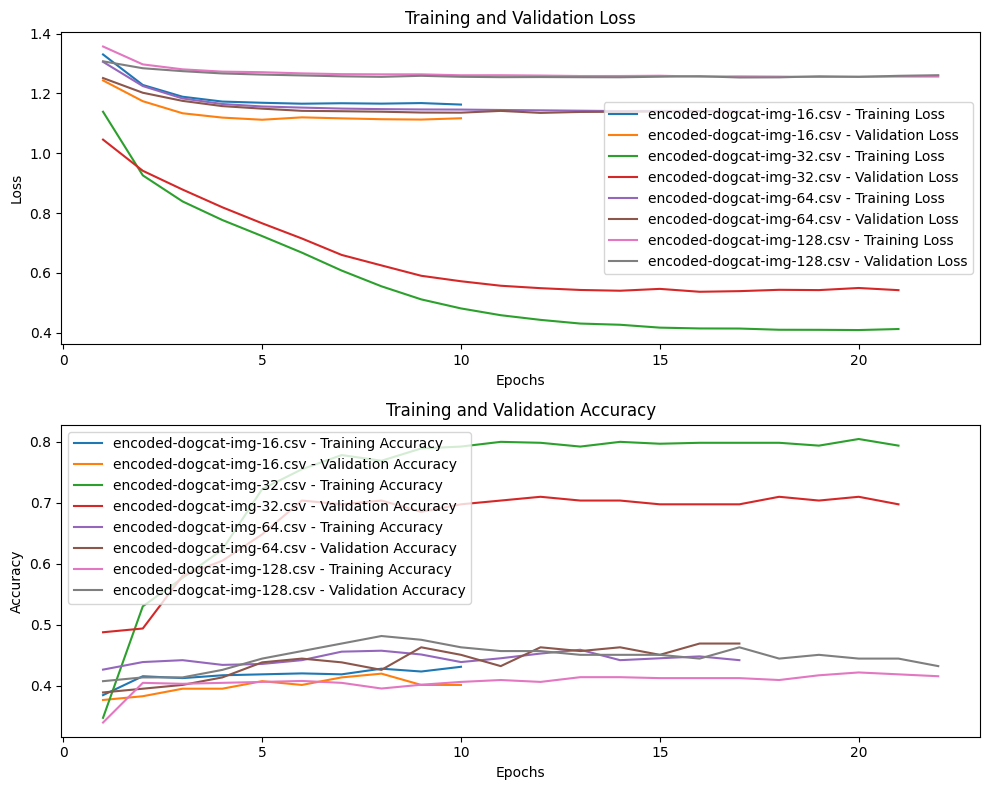

In [66]:
plt.figure(figsize=(10, 8))

# Plot loss
plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama
for i, history in enumerate(histories):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label=f'{file_names[i]} - Training Loss')
    plt.plot(epochs, history.history['val_loss'], label=f'{file_names[i]} - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot akurasi
plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua
for i, history in enumerate(histories):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label=f'{file_names[i]} - Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label=f'{file_names[i]} - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [67]:
res_nn_model = pd.DataFrame({
    'dataset_source': file_names,
    'accuracy' : accuracies
})

res_nn_model.head()

,dataset_source,accuracy
0,encoded-dogcat-img-16.csv,0.401235
1,encoded-dogcat-img-32.csv,0.697531
2,encoded-dogcat-img-64.csv,0.469136
3,encoded-dogcat-img-128.csv,0.432099
